# Pipeline for Training and Analysis of 20 2x100 FC models

## Imports and Hyperparameters

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Subset

from PIL import Image

from src.cifar.models import *
from src.util import split_train_val, test, train, save_model

import matplotlib.pyplot as plt
import matplotlib

import os

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# this should print 'cuda' if you are assigned a GPU
print(device)

train_batch_size = 100
test_batch_size = 100
n_epochs = 5
learning_rate = 1e-2
seed = 100
input_dim = 2
out_dim = 3 # 4
num_hidden_layers = 2
layer_size = 10
momentum = 0.9
weight_decay_lam = 0.0001

fc_model_params = [(1,10), (2,10), (3,10), (4,10)]

complex_models = []

PLOT_DIR = "TOY4"

cuda


## Generate Data

torch.Size([900, 2])
torch.Size([900])


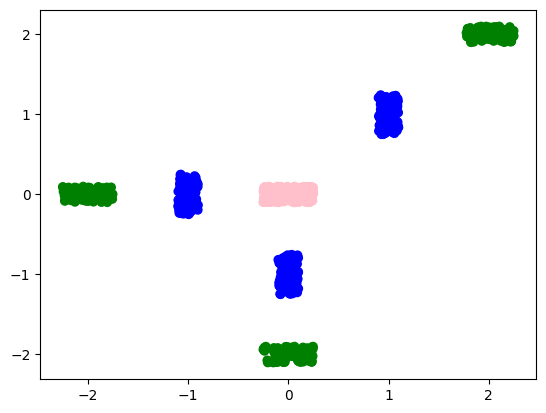

In [12]:
# centers = [(1,1), (-1,-1), (-1,1), (1,-1)]
# centers = [(1,0), (0,-1), (-1,0), (0,1)]
# centers = [(0,0)]*4
centers = [(1,1), (0,-1), (-1,0)]
data = torch.FloatTensor()
labels = torch.FloatTensor()
for i in range(out_dim):
    for center in centers:
        x_c = center[0]*i
        y_c = center[1]*i

        if i % 2 == 0:
            x_offset = 0.25
            y_offset = 0.1
        else:
            x_offset = 0.1
            y_offset = 0.25

        """if x_c < 0:
            x_offset *= -1
        if y_c < 0:
            y_offset *= -1"""

        x = torch.FloatTensor(100).uniform_(x_c-x_offset,x_c+x_offset)
        y = torch.FloatTensor(100).uniform_(y_c-y_offset,y_c+y_offset)
        new_labels = torch.FloatTensor(100).fill_(i)
        points = torch.stack([x,y], axis=1)

        data = torch.cat([data, points])
        labels = torch.cat([labels, new_labels])

print(data.shape)
print(labels.shape)

colors = ["pink", "blue", "green"] # , "yellow"]

plt.scatter([x[0] for x in data], [x[1] for x in data], c=[x for x in labels], cmap=matplotlib.colors.ListedColormap(colors))
plt.savefig("plots/" + PLOT_DIR + "/distribution.png")

In [13]:
train_dataset = torch.utils.data.TensorDataset(data, labels)
train_dataset, val_dataset = split_train_val(train_dataset, valid_ratio=1/6)
print('training data size:{}'.format(len(train_dataset)))
print('validation data size:{}'.format(len(val_dataset)))

training data size:750
validation data size:150


## Loaders

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
#raw_test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

# sanity check
print('training data size:{}'.format(len(train_loader.dataset)))
print('validation data size:{}'.format(len(val_loader.dataset)))
#print('test data size:{}'.format(len(test_loader.dataset)))

training data size:750
validation data size:150


## Create Networks

In [15]:
fc_models = [FC(input_dim, out_dim, num_hidden_layers, layer_size) for num_hidden_layers, layer_size in fc_model_params]
complex_models = load_pretrained_models(complex_models)

## Train Networks

In [16]:
for i, model in enumerate(fc_models):
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay_lam)

    print("Training FC model {}".format(i+1))

    for epoch in range(1, n_epochs + 1):
        train(model, train_loader, optimizer, epoch, device)

    test(model, val_loader, device)

    print("Saving FC model: {}".format(model))
    save_model(model, dataset=PLOT_DIR, filename="FC" + str(i))

for i, model in enumerate(os.listdir("./models/" + PLOT_DIR + "/")):
    if model.endswith(".pth") and "FC" in model:
        fc_models[i].load_state_dict(torch.load("./models/" + PLOT_DIR + "/" + model))
        with torch.no_grad():
            test(fc_models[i].to(device), train_loader, device)

Training FC model 1

Train Epoch: 1 [0/750 (0%)]	Loss: 1.190486
	Accuracy: 49.33%

Train Epoch: 2 [0/750 (0%)]	Loss: 1.132965
	Accuracy: 45.60%

Train Epoch: 3 [0/750 (0%)]	Loss: 1.071057
	Accuracy: 27.47%

Train Epoch: 4 [0/750 (0%)]	Loss: 1.037249
	Accuracy: 32.00%

Train Epoch: 5 [0/750 (0%)]	Loss: 1.014524
	Accuracy: 32.13%
Test set: Avg. loss: -0.5540, Accuracy: 66/150 (44.00%)
Saving FC model: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=3, bias=True)
  )
)
Training FC model 2

Train Epoch: 1 [0/750 (0%)]	Loss: 1.160623
	Accuracy: 33.07%

Train Epoch: 2 [0/750 (0%)]	Loss: 1.107920
	Accuracy: 33.07%

Train Epoch: 3 [0/750 (0%)]	Loss: 1.114884
	Accuracy: 33.07%

Train Epoch: 4 [0/750 (0%)]	Loss: 1.067567
	Accuracy: 51.20%

Train Epoch: 5 [0/750 (0%)]	Loss: 1.043535
	Accuracy: 60.13%
Test set: Avg. loss: -0.3634, Accuracy: 80/150 (53.33%)
Saving FC model: FC(
  (layer_list): ModuleList(
    (0

## Missclassification Tracking

Images tracked as tuples (batch_idx, image_idx) and can be accessed from dataset as test_dataset[batch_idx][image_idx]

In [17]:
misses = dict()
complex_list = list(complex_models.values())
for model in fc_models + complex_list:
    print("Starting model test: {}".format(model))

    model.to(device)
    model.eval()

    with torch.no_grad():
        
        for i, (data, target) in enumerate(val_loader):

            data = data.to(device)
            target = target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            missed = pred.not_equal(target.data.view_as(pred)).view(-1).cpu().numpy()

            for j, miss in enumerate(missed):
                if miss:
                    if (i, j) in misses:
                        misses[(i, j)] += 1
                    else:
                        misses[(i, j)] = 1

    print("Finished")

Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=3, bias=True)
  )
)
Finished
Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)
Finished
Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=3, bias=True)
  )
)
Finished
Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10

In [18]:
all_miss = {k: v for k, v in misses.items() if v > 0}
significant = {k: v for k, v in misses.items() if v > 19}
print(len(significant))
print(len(all_miss))

0
144


In [19]:
y = list(all_miss.values()) + [0]*(len(val_dataset)-len(all_miss))

fig = plt.figure(figsize=(12, 8), facecolor="w")
plt.hist(y, [x-0.5 for x in range(22)], edgecolor="k")
plt.xlabel("Number of Missclassifications")
plt.ylabel("Frequency")
plt.savefig("plots/" + PLOT_DIR + "/im_freq.png")
plt.close()

## Draw Decision Boundaries

/home/willi/.virtualenvs/workspace/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4192: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.asanyarray(c, dtype=float)


Completed model 1
Completed model 2
Completed model 3
Completed model 4


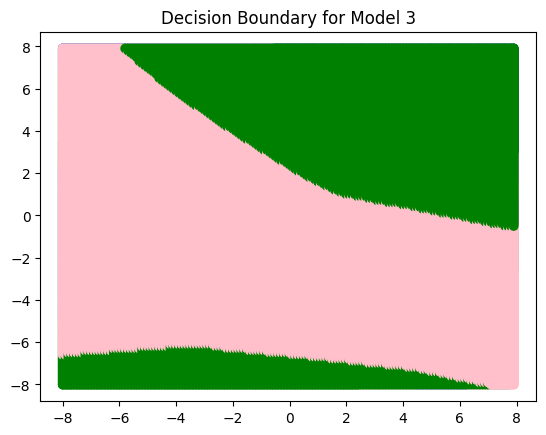

In [20]:
xs = np.arange(-8,8,.1)
ys = np.arange(-8,8,.1)

for i, model in enumerate(fc_models):
    points = []
    preds = []
    model.to(device)
    for x in xs:
        for y in ys:

            points.append((x,y))

            with torch.no_grad():
                preds.append(model(torch.FloatTensor([x,y]).to(device)).argmax(dim=1, keepdim=False))

    plt.scatter([x[0] for x in points], [y[1] for y in points], c=[x.cpu() for x in preds], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title("Decision Boundary for Model {}".format(i))
    plt.savefig("plots/" + PLOT_DIR + "/boundary_{}".format(i))
    print("Completed model {}".format(i+1))